In [1]:
# Importing all vision-related functions, classes, and utilities from fastai
# This gives us easy access to tools for loading, training, and evaluating deep learning models for image data.
from fastai.vision.all import *

# Setting a fixed random seed to make our results reproducible
# This ensures that the model, dataset shuffling, and other random processes give the same results every time we run the code.
set_seed(42)

# Importing parallel processing tools from fastcore
# This helps speed up certain operations by running them in parallel across multiple CPU cores.
from fastcore.parallel import *

# Importing data core utilities from fastai
# These are helpful for handling datasets, data loaders, and other data pipeline-related tasks.
from fastai.data.core import *

# Importing PyTorch, the backbone library behind fastai
# We'll use PyTorch for tensor operations, GPU acceleration, and defining deep learning models.
import torch

# Importing the time module to measure execution time of code blocks
# Useful for tracking how long training or data processing steps take.
import time


In [2]:
import pandas as pd
from pathlib import Path

train_metadata_path = Path('/Users/Yashwanth/isic/train-metadata.csv')

#  Delete all exciting files so there will be no overlaping  


In [ ]:
# Path to the working directory
working_dir = 'C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection'

# Loop through all files and folders in the directory
for filename in os.listdir(working_dir):
    file_path = os.path.join(working_dir, filename)
    try:
        # Check if it's a file or a folder
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Delete the file
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Delete the folder and its contents
    except Exception as e:
        print(f'Failed to delete {file_path}. Reason: {e}')

print("All files and folders in the working directory have been deleted.")

Failed to delete C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection\.git. Reason: [WinError 5] Access is denied: 'C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection\\.git\\objects\\02\\77b99e76736daccaf050c824a843bf85d2aa1d'
Failed to delete C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection\Fastai. Reason: [WinError 32] The process cannot access the file because it is being used by another process: 'C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection\\Fastai'
All files and folders in the working directory have been deleted.


In [3]:
# Looked at the sizes of the images to select the optimal one
# Takes a while so I just commented it 
'''from pathlib import Path
from PIL import Image
from collections import defaultdict

def get_image_sizes_and_counts(images_path):
    # Ensure images_path is a Path object
    images_path = Path(images_path)
    
    # Dictionary to store image sizes and their counts
    size_counts = defaultdict(int)
    
    # Iterate over all image files in the directory
    for img_path in images_path.glob('*'):
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                size_counts[(width, height)] += 1
        except Exception as e:
            print(f"Error opening {img_path}: {e}")
    
    return size_counts

# Define the path to your images
images_path = Path('/kaggle/input/isic-2024-challenge/train-image/image/')

# Get all image sizes and their counts
size_counts = get_image_sizes_and_counts(images_path)

 # Convert dictionary to list of tuples and sort by count
sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)

# Get top 5 sizes
top_5_sizes = sorted_sizes[:5]

print(top_5_sizes)'''

'from pathlib import Path\nfrom PIL import Image\nfrom collections import defaultdict\n\ndef get_image_sizes_and_counts(images_path):\n    # Ensure images_path is a Path object\n    images_path = Path(images_path)\n    \n    # Dictionary to store image sizes and their counts\n    size_counts = defaultdict(int)\n    \n    # Iterate over all image files in the directory\n    for img_path in images_path.glob(\'*\'):\n        try:\n            with Image.open(img_path) as img:\n                width, height = img.size\n                size_counts[(width, height)] += 1\n        except Exception as e:\n            print(f"Error opening {img_path}: {e}")\n    \n    return size_counts\n\n# Define the path to your images\nimages_path = Path(\'/kaggle/input/isic-2024-challenge/train-image/image/\')\n\n# Get all image sizes and their counts\nsize_counts = get_image_sizes_and_counts(images_path)\n\n # Convert dictionary to list of tuples and sort by count\nsorted_sizes = sorted(size_counts.items()

Based on the code aboce top 5 are

	•   (133, 133): 21,049 images
	•	(131, 131): 20,906 images
	•	(129, 129): 20,379 images
	•	(135, 135): 20,364 images
	•	(137, 137): 18,927 images
    
so I took the standard size =137,137

# Cleaning metadata

In [5]:
import pandas as pd  # For handling and processing tabular data
train_metadata_path = "C:/Users/Yashwanth/isic/train-metadata.csv"  

# Load metadata append
df = pd.read_csv(train_metadata_path, low_memory=False)

# Drop specified columns
columns_to_drop = ['copyright_license', 'attribution', 'image_type', 'iddx_1', 'iddx_2', 'iddx_3', 'iddx_4',
                   'iddx_5', 'iddx_full', 'mel_mitotic_index', 'mel_thick_mm', 'tbp_tile_type', 
                   'tbp_lv_dnn_lesion_confidence', 'lesion_id']

# Define categorical and continuous columns
cat_names = ['sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple']
cont_names = [x for x in df.columns if x not in (cat_names + ['target', 'isic_id', 'patient_id'] + columns_to_drop)]
y_col = 'target'
image_col = 'isic_id'


This code loads the training metadata from a CSV file, removes columns we don’t need, and separates the remaining data into categorical and numerical features.
It also sets the column for our prediction label (target) and the column that holds the image IDs (isic_id).
This setup makes the data ready for use in a machine learning or deep learning model.

In [6]:
def process_data(df, cat_names):
    
    
    # Drop columns 
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Add number of pictures for each patient
    df['numb_pic'] = df.groupby('patient_id')['patient_id'].transform('count')
    
    # Fill missing values with the mode
    if 'age_approx' in df.columns:
        mode_age = df['age_approx'].mode()[0]
        df['age_approx'] = df['age_approx'].fillna(mode_age)
    
    if 'sex' in df.columns:
        mode_sex = df['sex'].mode()[0]
        df['sex'] = df['sex'].fillna(mode_sex)
    
    # Convert categorical columns to dummies
    df = pd.get_dummies(df, columns=cat_names, prefix=cat_names)
    
    # Get new categorical column names
    new_cat_columns = [col for col in df.columns if any(col.startswith(name + '_') for name in cat_names)]
    
    # Ensure 'isic_id' in df has the correct file extension
    # if 'isic_id' in df.columns:
    #     df['isic_id'] = df['isic_id'].apply(lambda x: x.strip() + '.jpg')
    
    return df, new_cat_columns

#Apply to df
df, new_cat_columns= process_data(df,cat_names)  

In [7]:
def save_columns_to_csv(columns_list, file_path):
    df = pd.DataFrame(columns_list, columns=['new_cat_columns'])
    df.to_csv(file_path, index=False)

# Example usage
save_columns_to_csv(new_cat_columns, 'C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection/new_cat_columns.csv')  # ✅ correct


This function takes a list of column names and saves them into a CSV file.
It wraps the list in a DataFrame with a single column called new_cat_columns, then writes it to the given file path.
This is useful for keeping track of newly created or selected categorical features so they can be reused later without manually extracting them again.

# Oversampling

In [8]:
import h5py
import numpy as np
import random
from PIL import Image, ImageEnhance
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def augment_image(image_array, target_size=(137, 137)):
    # Convert numpy array to PIL image
    pil_image = Image.fromarray(image_array)
    
    # Randomly adjust hue, contrast, rotation, etc.
    if random.random() > 0.5:
        enhancer = ImageEnhance.Contrast(pil_image)
        pil_image = enhancer.enhance(random.uniform(0.8, 1.2))
    if random.random() > 0.5:
        enhancer = ImageEnhance.Color(pil_image)
        pil_image = enhancer.enhance(random.uniform(0.8, 1.2))
    if random.random() > 0.5:
        pil_image = pil_image.rotate(random.uniform(-10, 10), resample=Image.Resampling.BICUBIC, expand=True)
    
    # Resize the image to the target size without padding
    pil_image = pil_image.resize(target_size, resample=Image.Resampling.BICUBIC)
    
    # Convert PIL image back to numpy array
    return np.array(pil_image)

def resize_and_pad_image(image_array, standard_size=(137, 137)):
    if image_array.size == 0:
        raise ValueError("The image array is empty.")
    
    if len(image_array.shape) not in [2, 3]:
        raise ValueError(f"Unexpected image_array shape: {image_array.shape}")

    if image_array.ndim == 2:  # Grayscale image
        image_array = np.stack([image_array] * 3, axis=-1)
    elif image_array.ndim == 3 and image_array.shape[2] == 1:  # Single-channel image
        image_array = np.concatenate([image_array] * 3, axis=-1)
    
    old_size = image_array.shape[:2]  # original size (height, width)
    new_size = standard_size  # (width, height)

    if not isinstance(new_size, tuple) or len(new_size) != 2:
        raise ValueError(f"Expected standard_size to be a tuple of length 2, got {new_size}")

    if not old_size:
        raise ValueError("The old_size is empty. Cannot resize an image with unknown dimensions.")

    ratio = float(new_size[0]) / max(old_size)
    new_image_size = (int(old_size[1] * ratio), int(old_size[0] * ratio))

    if not isinstance(new_image_size, tuple) or len(new_image_size) != 2:
        raise ValueError(f"Expected new_image_size to be a tuple of length 2, got {new_image_size}")

    try:
        pil_image = Image.fromarray(image_array)
        resized_image = pil_image.resize(new_image_size, resample=Image.Resampling.LANCZOS)
        resized_image_array = np.array(resized_image)
        
        new_image = np.ones((new_size[1], new_size[0], image_array.shape[2]), dtype=np.uint8) * 255
        
        top = (new_size[1] - new_image_size[1]) // 2
        left = (new_size[0] - new_image_size[0]) // 2
        
        new_image[top:top + new_image_size[1], left:left + new_image_size[0]] = resized_image_array

    except Exception as e:
        print(f"Failed to process image: {e}")
        return np.zeros(standard_size + (image_array.shape[2],), dtype=np.uint8)  # Return a blank image if processing fails
    
    return new_image

def save_image_to_hdf5(hdf5_file, image_array, image_name, group_name):
    try:
        # Resize and pad the image
        image_array = resize_and_pad_image(image_array, standard_size=(137, 137))
        hdf5_file[group_name].create_dataset(image_name, data=image_array, compression="gzip", compression_opts=9)
        return image_name
    except Exception as e:
        print(f"Failed to save image {image_name}: {e}")
        return None

def read_image_from_folder(input_folder, img_name):
    img_path = f"{input_folder}/{img_name}.jpg"
    image = Image.open(img_path)
    return np.array(image)

def synthetic_oversample(df, column):
    # Replace this function with your synthetic oversampling logic
    return random.choice(df[column].values)

def oversample_data(input_folder, df, oversample_count=10000, undersample_count=10000, output_hdf5_path='oversampled_images.hdf5', batch_size=100):
    cancer_df = df[df['target'] == 1]
    non_cancer_df = df[df['target'] == 0].sample(n=undersample_count, random_state=42)

    # Oversample the minority class
    oversampled_rows = []
    cancer_len = len(cancer_df)
    for i in range(oversample_count - cancer_len):
        new_row = {}
        original_row = cancer_df.iloc[i % cancer_len]  # Reuse rows as needed
        new_row['isic_id'] = f"{original_row['isic_id']}_oversampled_{(i // cancer_len) + 1}"
        new_row['target'] = 1
        for column in df.columns:
            if column != 'isic_id' and column != 'target':
                new_row[column] = synthetic_oversample(cancer_df, column)
        oversampled_rows.append(new_row)
    
    oversampled_df = pd.DataFrame(oversampled_rows)
    combined_df = pd.concat([non_cancer_df, cancer_df, oversampled_df], ignore_index=True)

    # Save images to HDF5
    with h5py.File(output_hdf5_path, 'w') as hdf_out:
        hdf_out.create_group('oversampled_images')
        futures = []
        with ThreadPoolExecutor() as executor:
            # Process non-cancer and original cancer images
            for i in range(0, len(combined_df), batch_size):
                batch_files = combined_df['isic_id'].tolist()[i:i + batch_size]
                for img_name in tqdm(batch_files, desc=f"Processing batch {i // batch_size + 1}"):
                    try:
                        if '_oversampled_' not in img_name:  # Original images
                            img_data = read_image_from_folder(input_folder, img_name)
                        else:  # Augmented images
                            original_img_name = img_name.split('_oversampled_')[0]
                            img_data = read_image_from_folder(input_folder, original_img_name)
                            img_data = augment_image(img_data)
                        
                        futures.append(executor.submit(save_image_to_hdf5, hdf_out, img_data, img_name, 'oversampled_images'))
                    except Exception as e:
                        print(f"Failed to process image {img_name}: {e}")
                
                for future in as_completed(futures):
                    future.result()

    return combined_df

This code creates extra training data for the cancer class. It copies/augments images to balance classes, resizes them to a consistent shape, and stores everything neatly in a single HDF5 file. It also returns an updated DataFrame with both original and synthetic rows so you can train your model straight away.

In [9]:
from pathlib import Path

input_folder = Path("C:/Users/Yashwanth/isic/train-image/image")
output_hdf5_path = Path("C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection/Oversampled_small.hdf5")

# Ensure output directory exists
output_hdf5_path.parent.mkdir(parents=True, exist_ok=True)


 The raw images live and where the output HDF5 file should be saved. Then we make sure the output folder exists so the save step won’t crash later.

In [10]:
# Balance dataset by over/under sampling and save as HDF5

# Folder with original training images
input_folder = Path("C:/Users/Yashwanth/isic/train-image/image")

# Path to save balanced dataset
output_hdf5_path = Path("C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection/Oversampled_small.hdf5")

# Perform oversampling/undersampling and save result
combined_df = oversample_data(
    input_folder,
    df,
    undersample_count=100000,
    oversample_count=10000,
    output_hdf5_path=output_hdf5_path
)


Processing batch 1100: 100%|██████████| 100/100 [00:00<00:00, 363.98it/s]


In [11]:
# Save balanced DataFrame to CSV
csv_path = Path("C:/Users/Yashwanth/ISIC24_Skin_Cancer_Detection/Small_df5.csv")
combined_df.to_csv(csv_path, index=False)

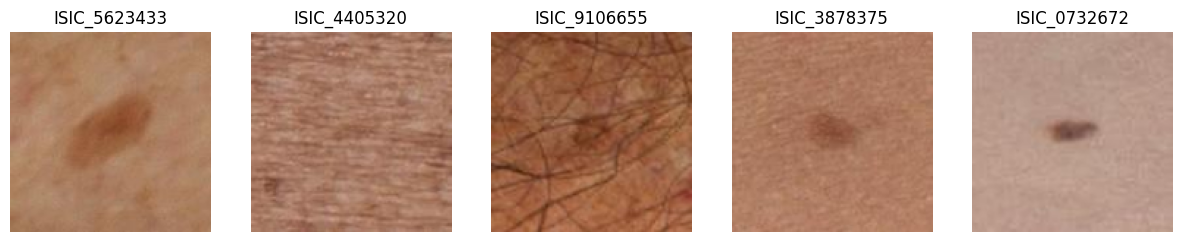

In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import random

def show_random_images_from_hdf5(hdf5_path, num_images=5):
    """
    Display a random sample of images from an HDF5 file.

    :param hdf5_path: Path to the HDF5 file.
    :param num_images: Number of random images to display.
    """
    try:
        with h5py.File(hdf5_path, 'r') as hdf_file:
            # Get all image keys from the HDF5 file
            image_keys = list(hdf_file['oversampled_images'].keys())
            
            if len(image_keys) < num_images:
                raise ValueError(f"Not enough images in the HDF5 file to display {num_images} images.")
            
            # Randomly select a subset of image keys
            selected_keys = random.sample(image_keys, num_images)
            
            fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
            if num_images == 1:
                axes = [axes]
            
            for ax, key in zip(axes, selected_keys):
                # Load image data from the HDF5 file
                img_data = hdf_file['oversampled_images'][key][()]
                ax.imshow(img_data)
                ax.set_title(key)
                ax.axis('off')
            
            plt.show()
    
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
show_random_images_from_hdf5(output_hdf5_path)

This function opens the HDF5 file, picks a few random images from "oversampled_images", and displays them using matplotlib. It first collects all image keys, randomly selects the required number, loads each image, and shows them without axes. If there’s an error, it prints a message.
